## Sports Analytics Using Pyspark sql and Mllib 

We will be working on a dataset that contains nba players information on various scoring styles such as how many points they scored based on year ,how they scored their points , impact they had ,.etc 



## Creating a Spark Session 


In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark=SparkSession.builder.appName('SportsDataAnalyticsSpark').getOrCreate()

In [ ]:
spark

## Importing Necessary Libaries 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns


from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.sql import SQLContext
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf


Creating a Spark Datafrom from The data 

In [ ]:
df = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('season_totals.csv')

# Information about the data : 




In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- player: string (nullable = true)
 |-- pos: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- team_id: string (nullable = true)
 |-- g: integer (nullable = true)
 |-- gs: integer (nullable = true)
 |-- mp: integer (nullable = true)
 |-- fg: integer (nullable = true)
 |-- fga: integer (nullable = true)
 |-- fg_pct: double (nullable = true)
 |-- fg3: integer (nullable = true)
 |-- fg3a: integer (nullable = true)
 |-- fg3_pct: double (nullable = true)
 |-- fg2: integer (nullable = true)
 |-- fg2a: integer (nullable = true)
 |-- fg2_pct: double (nullable = true)
 |-- efg_pct: double (nullable = true)
 |-- ft: integer (nullable = true)
 |-- fta: integer (nullable = true)
 |-- ft_pct: double (nullable = true)
 |-- orb: integer (nullable = true)
 |-- drb: integer (nullable = true)
 |-- trb: integer (nullable = true)
 |-- ast: integer (nullable = true)
 |-- stl: integer (nullable = true)
 |-- blk: integer (nullable = true)
 |-- tov: 

## Description of the features : 

---
mp - Minutes Played 

---

fg -  a field goal is a basket scored on any shot or tap other than a free throw, worth two or three depending on the distanc of the throw 

---
g - No of Games A player has played 

---
gs - no of games started 

---


efg_pct - effective field goal percentage

---

ft - number of free throws 


Dropping Null Values of the data 


In [ ]:
df = df.na.drop()

In [ ]:
df.show()

+---+----------------+-----+---+-------+---+---+----+---+----+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+----+----+
|_c0|          player|  pos|age|team_id|  g| gs|  mp| fg| fga|fg_pct|fg3|fg3a|fg3_pct|fg2|fg2a|fg2_pct|efg_pct| ft|fta|ft_pct|orb|drb|trb|ast|stl|blk|tov| pf| pts|  yr|
+---+----------------+-----+---+-------+---+---+----+---+----+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+----+----+
|  3|  Archibald,Tiny|   PG| 31|    BOS| 80| 80|2864|383| 794| 0.482|  4|  18|  0.222|379| 776|  0.488|  0.485|361|435|  0.83| 59|138|197|671|106| 10|242|218|1131|1980|
| 21|      Bird,Larry|   PF| 23|    BOS| 82| 82|2955|693|1463| 0.474| 58| 143|  0.406|635|1320|  0.481|  0.494|301|360| 0.836|216|636|852|370|143| 53|263|279|1745|1980|
| 54|       Carr,M.L.|   SF| 29|    BOS| 82|  7|1994|362| 763| 0.474| 12|  41|  0.293|350| 722|  0.485|  0.482|178|241| 0.739|106|224|330|156|120| 36|143|2

## Using spark Sql : 

In [ ]:
# Creating Table Using Sql 
df.registerTempTable('SeasonsTable')
sqlContext = SQLContext(spark)

# Running Query : 
df1 = sqlContext.sql("SELECT * FROM SeasonsTable").toPandas()
df2 = sqlContext.sql("SELECT player As Player_Name,mp as Minutes_Played FROM SeasonsTable where mp > 1500").toPandas()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
df2

,Player_Name,Minutes_Played
0,"Archibald,Tiny",2864
1,"Bird,Larry",2955
2,"Carr,M.L.",1994
3,"Cowens,Dave",2159
4,"Ford,Chris",2115
...,...,...
5838,"Williams,Lou",1907
5839,"Williams,Marvin",2338
5840,"Winslow,Justise",2232
5841,"Young,Thaddeus",2407


# Data Visualizaion 


Text(0.5, 1.0, 'Free Throws  VS Total Points')

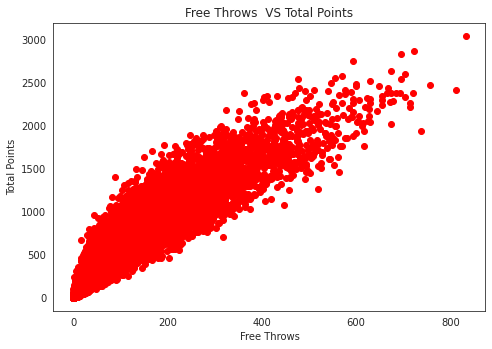

In [ ]:
# Visualising some variables relations 

df3 = sqlContext.sql("SELECT ft,pts from SeasonsTable").toPandas()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(df3['ft'],df3['pts'],color = 'r')
ax.set_xlabel('Free Throws')
ax.set_ylabel('Total Points')
ax.set_title("Scatter Plot")
plt.title("Free Throws  VS Total Points")

Free throws for players whose points scored are greater than 2000 : 


Text(0.5, 1.0, 'Free Throws  VS Total Points')

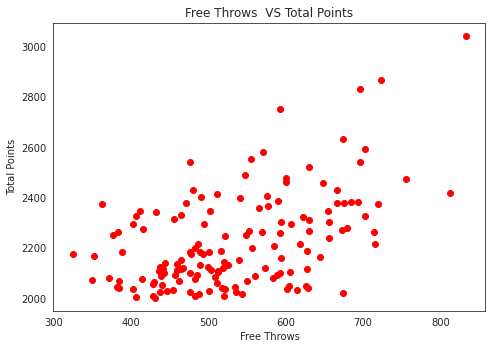

In [ ]:
df3 = sqlContext.sql("SELECT ft,pts from SeasonsTable Where pts > 2000").toPandas()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(df3['ft'],df3['pts'],color = 'r')
ax.set_xlabel('Free Throws')
ax.set_ylabel('Total Points')
ax.set_title("Scatter Plot")
plt.title("Free Throws  VS Total Points")

In [ ]:
#3d Scatter Plot
df4 = sqlContext.sql("SELECT mp, fg,pts from SeasonsTable Limit 50").toPandas()


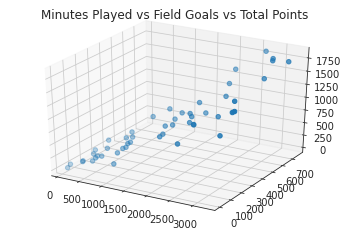

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(df4['mp'], df4['fg'], df4['pts'] )
ax.set_title("Minutes Played vs Field Goals vs Total Points")
plt.show()

In [ ]:
# Visualising without using Sql Context 
df.orderBy('pts',ascending = False).limit(10).toPandas()[['yr','player','age','pts','fg3']]

,yr,player,age,pts,fg3
0,1987,"Jordan,Michael",23,3041,12
1,1988,"Jordan,Michael",24,2868,7
2,2006,"Bryant,Kobe",27,2832,180
3,1990,"Jordan,Michael",26,2753,92
4,1989,"Jordan,Michael",25,2633,27
5,2014,"Durant,Kevin",25,2593,192
6,1991,"Jordan,Michael",27,2580,29
7,1982,"Gervin,George",29,2551,10
8,1993,"Jordan,Michael",29,2541,81
9,1990,"Malone,Karl",26,2540,16


In [ ]:
print(df.columns)

['_c0', 'player', 'pos', 'age', 'team_id', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'fg2', 'fg2a', 'fg2_pct', 'efg_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'yr']


Fg - field goals per 36 minutes


In [ ]:
# Industry Standart To analyse field goals of three attempts per 36 Minutes 
# Calculating Average Number of 3 pointers by a player for Each Season 

# We use Sql Context to sort the data out 
fg3a = sqlContext.sql('''SELECT yr,
                                SUM(fg3a)/sum(mp)*36 as fg3a_36Min
                                FROM SeasonsTable GROUP BY yr 
                                ORDER BY yr''')

In [ ]:
print(fg3a.toPandas())

      yr  fg3a_36Min
0   1980    0.890373
1   1981    0.463713
2   1982    0.386214
3   1983    0.360501
4   1984    0.401499
5   1985    0.525643
6   1986    0.558114
7   1987    0.759096
8   1988    0.838031
9   1989    1.060706
10  1990    1.048730
11  1991    1.140319
12  1992    1.198594
13  1993    1.422610
14  1994    1.578435
15  1995    2.445009
16  1996    2.509720
17  1997    2.708351
18  1998    2.116324
19  1999    2.223769
20  2000    2.233470
21  2001    2.167104
22  2002    2.436838
23  2003    2.451621
24  2004    2.427012
25  2005    2.625455
26  2006    2.658149
27  2007    2.769910
28  2008    2.885697
29  2009    2.948457
30  2010    2.876176
31  2011    3.017326
32  2012    3.010563
33  2013    3.237350
34  2014    3.454093
35  2015    3.623507
36  2016    3.774527


We see the average 3 point attemps by a player [per 36 minutes] throughout the years 



Text(1998.5, 2.4, 'NBA moved back\n3-point line')

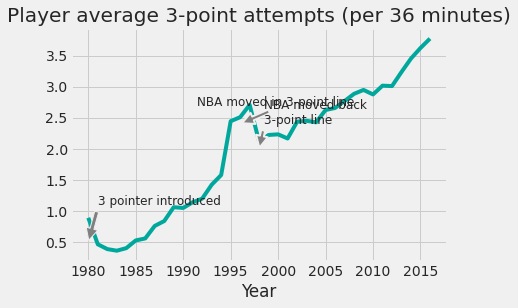

In [ ]:
from matplotlib import pyplot as plt 
import seaborn as sns
plt.style.use('fivethirtyeight')

_df = fg3a.toPandas()
plt.plot(_df.yr,_df.fg3a_36Min, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.annotate('3 pointer introduced', xy=(1980, .5), xytext=(1981, 1.1), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 1))
plt.annotate('NBA moved in 3-point line', xy=(1996, 2.4), xytext=(1991.5, 2.7), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12, arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))


We can see a steady rise in Number of 3 Point Attempts Since the shot's introduction in 1979-80 season and also a bit of decrease in the number in mid 90's when NBA moved the line in a few feet 

# Using Linear Regression To predict where the 3 point attempts by players will go for the next 5 years 

In [ ]:
# Using Linear Regression Model to See Where this Curve Goes for the Next 5 Years . 

VectorAssembler - A feature transformer that merges multiple columns into a vector column

In [ ]:
# Transforming our data using Vector Assembler Function to a single columns where Each Row of Datafraom Containts A Feature Vector 
from pyspark.ml.feature import VectorAssembler
t = VectorAssembler(inputCols=['yr'], outputCol = 'features')
training = t.transform(fg3a)\
            .withColumn('yr',fg3a.yr)\
            .withColumn('label',fg3a.fg3a_36Min)
training.toPandas().head()

,yr,fg3a_36Min,features,label
0,1980,0.890373,[1980.0],0.890373
1,1981,0.463713,[1981.0],0.463713
2,1982,0.386214,[1982.0],0.386214
3,1983,0.360501,[1983.0],0.360501
4,1984,0.401499,[1984.0],0.401499


In [ ]:
lr = LinearRegression(maxIter=10)
model = lr.fit(training)

In [ ]:
from pyspark.sql.types import Row

sc = spark.sparkContext # Spark Context

# apply model for the 1979-80 season thru 2020-21 season
training_yrs = training.select('yr').rdd.map(lambda x: x[0]).collect()
training_y = training.select('fg3a_36Min').rdd.map(lambda x: x[0]).collect()
prediction_yrs = [2017, 2018, 2019, 2020, 2021]
all_yrs = training_yrs + prediction_yrs

# built testing DataFrame
test_rdd = sc.parallelize(all_yrs)
row = Row('yr')
all_years_features = t.transform(test_rdd.map(row).toDF())

# apply linear regression model
df_results = model.transform(all_years_features).toPandas()

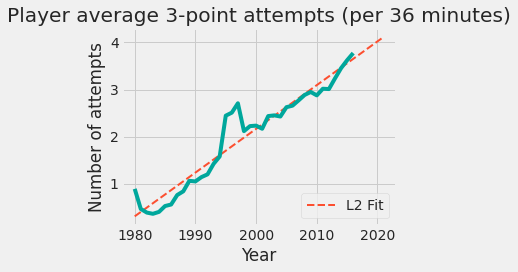

In [ ]:
# Plotting the result : 
plt.plot(df_results.yr,df_results.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.plot(training_yrs, training_y, color = '#00a79c', label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.tight_layout()
plt.savefig('model_prediction.png')

# K- means clustering 

In [ ]:
df.show()

+---+----------------+-----+---+-------+---+---+----+---+----+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+----+----+
|_c0|          player|  pos|age|team_id|  g| gs|  mp| fg| fga|fg_pct|fg3|fg3a|fg3_pct|fg2|fg2a|fg2_pct|efg_pct| ft|fta|ft_pct|orb|drb|trb|ast|stl|blk|tov| pf| pts|  yr|
+---+----------------+-----+---+-------+---+---+----+---+----+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+----+----+
|  3|  Archibald,Tiny|   PG| 31|    BOS| 80| 80|2864|383| 794| 0.482|  4|  18|  0.222|379| 776|  0.488|  0.485|361|435|  0.83| 59|138|197|671|106| 10|242|218|1131|1980|
| 21|      Bird,Larry|   PF| 23|    BOS| 82| 82|2955|693|1463| 0.474| 58| 143|  0.406|635|1320|  0.481|  0.494|301|360| 0.836|216|636|852|370|143| 53|263|279|1745|1980|
| 54|       Carr,M.L.|   SF| 29|    BOS| 82|  7|1994|362| 763| 0.474| 12|  41|  0.293|350| 722|  0.485|  0.482|178|241| 0.739|106|224|330|156|120| 36|143|2

Using Sql to group by player names and using it for k means 


In [ ]:
df_groupbyname = sqlContext.sql('''SELECT player as Player_Name,
                                          Sum(g) as Games_played ,Sum(mp) as Minutes_played,Sum(fga) as Field_Goals,Sum(ft) as Free_throws,Sum(pts) as Total_Points ,Sum(fta) as FreeThrowAttempts
                                          FROM SeasonsTable
                                          GROUP BY player
                                ''')


In [ ]:
df_groupbyname.show(10)

+-----------------+------------+--------------+-----------+-----------+------------+-----------------+
|      Player_Name|Games_played|Minutes_played|Field_Goals|Free_throws|Total_Points|FreeThrowAttempts|
+-----------------+------------+--------------+-----------+-----------+------------+-----------------+
|      Ainge,Danny|        1115|         30132|      10956|       1881|       13245|             2220|
|  Pressley,Harold|         299|          6802|       2458|        344|        2702|              442|
|  Garland,Winston|         590|         15153|       5017|       1004|        5373|             1209|
|     Oliver,Jimmy|          75|           835|        325|         44|         323|               57|
|     Brown,Marcus|          27|           229|         84|         15|          92|               21|
|    Byars,Derrick|           2|            37|         11|          4|          10|                4|
| McCullough,Chris|          24|           362|        109|         11|  

In [ ]:
df_groupbyname.columns

['Player_Name',
 'Games_played',
 'Minutes_played',
 'Field_Goals',
 'Free_throws',
 'Total_Points',
 'FreeThrowAttempts']

In [ ]:
input_cols = ['Games_played','Minutes_played','Field_Goals','Free_throws','Total_Points','FreeThrowAttempts']

In [ ]:
vec_assembler = VectorAssembler(inputCols = input_cols,outputCol = "features")

In [ ]:
final_data = vec_assembler.transform(df_groupbyname)

In [ ]:
final_data.show(10)

+-----------------+------------+--------------+-----------+-----------+------------+-----------------+--------------------+
|      Player_Name|Games_played|Minutes_played|Field_Goals|Free_throws|Total_Points|FreeThrowAttempts|            features|
+-----------------+------------+--------------+-----------+-----------+------------+-----------------+--------------------+
|      Ainge,Danny|        1115|         30132|      10956|       1881|       13245|             2220|[1115.0,30132.0,1...|
|  Pressley,Harold|         299|          6802|       2458|        344|        2702|              442|[299.0,6802.0,245...|
|  Garland,Winston|         590|         15153|       5017|       1004|        5373|             1209|[590.0,15153.0,50...|
|     Oliver,Jimmy|          75|           835|        325|         44|         323|               57|[75.0,835.0,325.0...|
|     Brown,Marcus|          27|           229|         84|         15|          92|               21|[27.0,229.0,84.0,...|
|    Bya

In [ ]:
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator



In [ ]:
kmeans = KMeans(featuresCol="features",k = 4)
model = kmeans.fit(final_data)

In [ ]:
model.transform(final_data).groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  148|
|         3|  505|
|         2|  308|
|         0| 1288|
+----------+-----+



In [ ]:
predictions = model.transform(final_data)



In [ ]:
predictions.show()

+-----------------+------------+--------------+-----------+-----------+------------+-----------------+--------------------+----------+
|      Player_Name|Games_played|Minutes_played|Field_Goals|Free_throws|Total_Points|FreeThrowAttempts|            features|prediction|
+-----------------+------------+--------------+-----------+-----------+------------+-----------------+--------------------+----------+
|      Ainge,Danny|        1115|         30132|      10956|       1881|       13245|             2220|[1115.0,30132.0,1...|         1|
|  Pressley,Harold|         299|          6802|       2458|        344|        2702|              442|[299.0,6802.0,245...|         3|
|  Garland,Winston|         590|         15153|       5017|       1004|        5373|             1209|[590.0,15153.0,50...|         3|
|     Oliver,Jimmy|          75|           835|        325|         44|         323|               57|[75.0,835.0,325.0...|         0|
|     Brown,Marcus|          27|           229|        

Seeing what impace the 3- point changes has had on Shot Selection 

In [ ]:
# df = spark.read\
#           .option('header', 'true')\
#           .option('inferSchema', 'true')\
#           .csv('1000_plus_shot_charts_2011_2016.csv')


In [ ]:
# Previewing The Data : 
# df.orderBy('game_date').limit(10).toPandas()


Quering at an Individual Player's Shot selection and visualising it . 

In [ ]:
# import numpy as np
# from nba_utils import plot_shot_chart # custom module based on code from Tjortjoglou
# sns.set_style("white")
 
# player = 'Stephen Curry'
# yr = '2016'
# df_steph = df.filter('''name == "{player}"
#                         and yr == {yr}
#                         and y < 400'''.format(player = player,
#                                               yr = yr))
# x = np.array([v[0] for v in df_steph.select('x').collect()])
# y = np.array([v[0] for v in df_steph.select('y').collect()])
# p=plot_shot_chart(x, y, gridsize = 30,
#                       kind='hex',
#                       label='Steph Curry\n2016')
# p.savefig('Steph_Curry_2016')

In [ ]:
def is_corner_3(xy):
    '''Want to identify corner 3 point attempts'''
    x,y = xy
    return int((abs(x) >= 220) and (y < 92.5))

def is_normal_3(xycorner3):
    '''Want to identify normal (not corner 3) point attempts'''
    x,y,corner3 = xycorner3
    radius = 475/2.
    y_3pt = np.sqrt(np.square(radius) - np.square(x))
    return int(y > max(92.5,y_3pt) and not corner3)

In [ ]:
from pyspark.sql.functions import array,udf
from pyspark.sql.types import IntegerType

corner_3_udf = udf(is_corner_3, IntegerType())
normal_3_udf = udf(is_normal_3, IntegerType())

df2 = df.withColumn('corner_3', corner_3_udf(array([df.x,df.y])))
df3 = df2.withColumn('normal_3', normal_3_udf(array([df2.x,df2.y,df2.corner_3])))
df4 = df3.withColumn('is_a_3', df3.corner_3 + df3.normal_3) 

df = df4
df.cache()

In [ ]:
from pyspark.sql.functions import mean
from nba_utils import draw_3pt_piechart # custom module/function - see GitHub repo

# make shot charts for all years
midrange_thresh = 8
in_half_court = 'y <= 400 and abs(x) <= 250' 
addl_filter = 'shot_distance > {midrange_thresh}'.format(midrange_thresh = midrange_thresh)
for yr in range(2011,2016+1):
    df_yr = df.filter('''{in_half_court}
                         and yr == {yr}
                         and {addl_filter}'''.format(in_half_court = in_half_court,
                                                     yr = yr,
                                                     addl_filter = addl_filter))
    x = np.array([v[0] for v in df_yr.select('x').collect()])
    y = np.array([v[0] for v in df_yr.select('y').collect()])
    p = plot_shot_chart(x,y, gridsize = 30, kind = 'kde', label = yr)
    p.fig.suptitle('Evolution of the 3 point shot', x = .19, y = 0.86, size = 20, fontweight= 'bold')
    
    per_3 = df_yr.select(mean(df_yr.is_a_3)).take(1)[0][0]
    per_midrange = 1 - per_3
    
    
    p.savefig('results/all_years/{}.png'.format(yr))
    plt.close()